# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает ***приложение для привлечения новых клиентов***. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно ***построить модель для определения стоимости***. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных.
<br>Признаки:
<br>DateCrawled — дата скачивания анкеты из базы
<br>VehicleType — тип автомобильного кузова
<br>RegistrationYear — год регистрации автомобиля
<br>Gearbox — тип коробки передач
<br>Power — мощность (л. с.)
<br>Model — модель автомобиля
<br>Kilometer — пробег (км)
<br>RegistrationMonth — месяц регистрации автомобиля
<br>FuelType — тип топлива
<br>Brand — марка автомобиля
<br>NotRepaired — была машина в ремонте или нет
<br>DateCreated — дата создания анкеты
<br>NumberOfPictures — количество фотографий автомобиля
<br>PostalCode — почтовый индекс владельца анкеты (пользователя)
<br>LastSeen — дата последней активности пользователя
<br>***Целевой признак:
<br>Price — цена (евро)***

## Подготовка данных

In [1]:
# Загрузка библиотек
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Путь к файлам
cost_model=pd.read_csv('/datasets/autos.csv') 
cost_model.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
# Проверка выборки на наличие дубликатов
cost_model.duplicated().sum()

4

На начальном этапе оставим только столбцы с признаками в т.ч. целевой признак влияющие непосредственно на ее цену и необходимые для правильного предсказания модели.
<br>Далее проверим типы данных полученных столбцов, аномалии, наличие в них пропусков, а также статистические данные по количественным признакам.

In [4]:
# Отбор столбцов для обучения-предсказания модели
cost_model_main = cost_model[['Price', 
                         'VehicleType', 
                         'RegistrationYear',
                         'Gearbox',
                         'Power',
                         'Model',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired']]
cost_model_main.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [5]:
# Проверка типов данных
cost_model_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [6]:
# Проверка выборки на предмет пропусков
cost_model_main.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

In [7]:
# Просмотр основных статистических данных
cost_model_main.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Просмотрим каждый признак с аномалиями и NaN более детально.

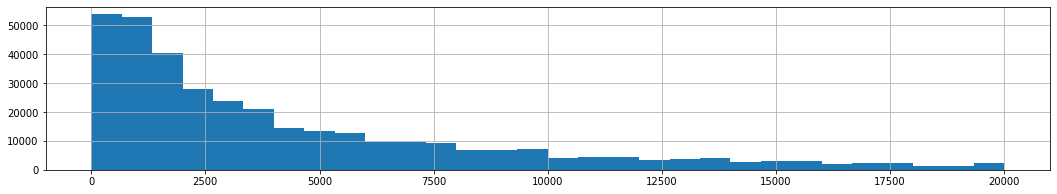

In [8]:
# Признак 'Price'_гистограмма
cost_model_main['Price'].hist(bins=30, figsize=(18,3))

In [9]:
cost_model_main['Price'].quantile([.05, 0.95])

0.05      200.0
0.95    14600.0
Name: Price, dtype: float64

In [10]:
cost_model_main = cost_model_main.query('200 <= Price <= 14600')

По признаку 'Price' исходя из распределения и квантилей оставили диапазон 200-14600.

In [11]:
# Признак 'VehicleType'
set(cost_model_main['VehicleType'])

{'bus', 'convertible', 'coupe', nan, 'other', 'sedan', 'small', 'suv', 'wagon'}

В признаке 'VehicleType' все NaN заменим на None.

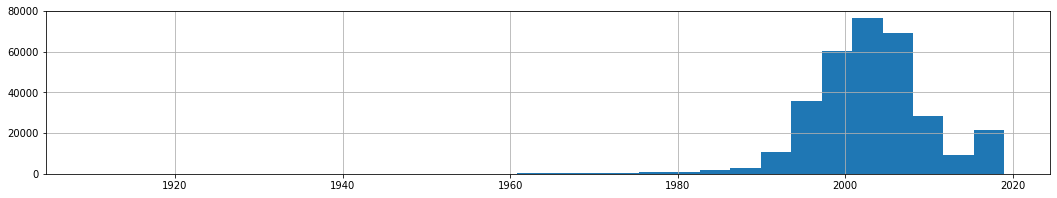

In [12]:
# Признак 'RegistrationYear'_гистограмма
cost_model_main = cost_model_main.query('1909 < RegistrationYear < 2020')
cost_model_main['RegistrationYear'].hist(bins=30, figsize=(18,3))

In [13]:
cost_model_main['RegistrationYear'].describe()

count    319157.000000
mean       2002.973941
std           7.123650
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

По признаку 'RegistrationYear' исходя из логики существования автомобилей оставили диапазон годов 1910-2019гг.

In [14]:
# Признак 'Gearbox'
set(cost_model_main['Gearbox'])

{'auto', 'manual', nan}

В признаке 'Gearbox' все NaN заменим на None.

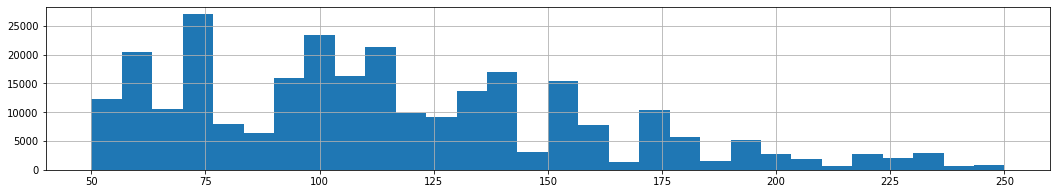

In [15]:
# Признак 'Power'_гистограмма
cost_model_main = cost_model_main.query('49 < Power < 251')
cost_model_main['Power'].hist(bins=30, figsize=(18,3))

По признаку 'Power' исходя из распределения представленных автомобилей оставили диапазон в 50-250 л.с., несмотря на наличие в природе самой быстрой машины в мире с 1600 л.с.)

In [16]:
# Признак 'Model'
cost_model_main['Model'].unique()

array(['grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'polo', 'twingo', 'a_klasse', 'scirocco', '5er',
       'meriva', 'arosa', 'other', 'c4', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'a8', 'jetta', 'astra', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', '156', nan, 'escort', 'forester', 'xc_reihe', 'scenic',
       'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'slk',
       'combo', 'corsa', '80', '147', 'z_reihe', 'sportage', 'sorento',
       'ibiza', 'eos', 'touran', 'getz', 'insignia', 'almera', 'megane',
       'a3', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'lupo', 'berlingo', '7er', 'tiguan', 'i_reihe',
       '6_reihe', 'panda', 'up', 'ceed', 'kangoo', 'yeti', 'octavia',
       'zafira', 'mii', 'rx_reihe', 'modus', 'fox', 'matiz', 'beetle',
       'rio', 'logan', 'spider', 'cuore', 's_max', 'a2', 'c3', '1_reihe',
       

В признаке 'Model' все NaN заменим на None, аналогично по 'FuelType', 'NotRepaired'.

In [17]:
set(cost_model_main['FuelType'])

{'cng', 'electric', 'gasoline', 'hybrid', 'lpg', nan, 'other', 'petrol'}

In [18]:
set(cost_model_main['NotRepaired'])

{nan, 'no', 'yes'}

In [19]:
# Замена на None
cost_model_main[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']] = cost_model_main[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']].fillna('None')
cost_model_main.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,None
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


Text(0.5, 1.0, 'Топ-10 марок автомобилей на продажу по данным сервиса')

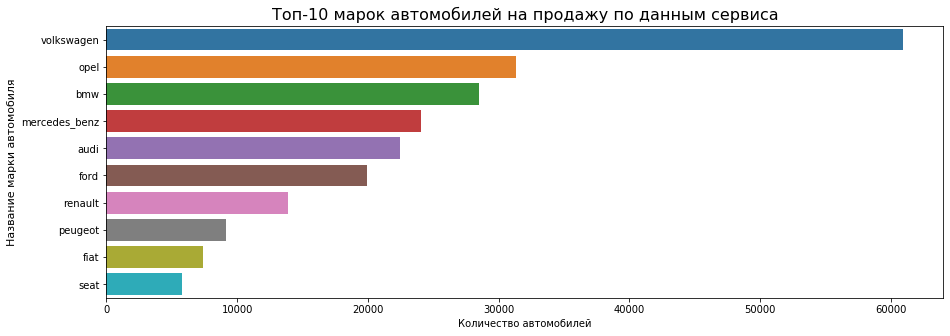

In [20]:
# Гистограмма марок автомобилей
brand = (cost_model_main['Brand']).value_counts().head(10)

plt.figure(figsize=(15,5))
sns.barplot(y=brand.index,x=brand)
plt.xlabel('Количество автомобилей')
plt.ylabel('Название марки автомобиля', fontsize=11)
plt.title('Топ-10 марок автомобилей на продажу по данным сервиса', fontsize=16)

Наиболее часто представлены на продажу на сервисе следующие марки: Volkswagen, Opel, BMW.

### Вывод:
Выборка проверена по типам данных, на предмет аномалий, пропусков, дубликатов; сформирован новый сокращенный датафрейм с метриками необходимыми для построения модели.
<br>Наиболее важные характеристики для анализа продаж сервиса являются 'Brand', 'Power' и 'Kilometer'.
<br>Метрики'Brand' и 'Power' имеют прямопропоцинальное влияние на цену автомобиля, из-за аномалий в признаке 'Power' введен корректный диапазон значений 50-250 л.с.
<br>Аналогичные правки аномалий проведены по метрикам 'Price' и 'RegistrationYear'.
<br>Метрика 'Kilometer' имеет обратнопропорциональное влияние на цену, выборка представлена диапазоном пробега 5000-150000км.
<br>По перечню признаков 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired' проведена замена значений на 'None'.

## Обучение моделей

Разделим выборку train_test_split, применим стандартизацию и масштабирование.
<br>Обучим и проверим точность моделей на тесте с помощью RMSE, сравним их скорость работы.

In [21]:
# Признаки
features = cost_model_main.drop('Price', axis=1)
# Целевой признак
target = cost_model_main['Price']

In [22]:
# Применение кодирования OrdinalEncoder
encoder = OrdinalEncoder()
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
main_features = features[categorical_features]
main_features = pd.DataFrame(encoder.fit_transform(main_features),
                                columns=main_features.columns, 
                                index=main_features.index)
ordinal_features = features.copy()
for column in categorical_features:
    ordinal_features[column] = main_features[column]

In [23]:
# Отделение 20% данных для тестовой выборки, на обучающую- 80%
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(220708, 9) (55177, 9) (220708,) (55177,)


In [24]:
#OHE-кодирование
ohe_features = pd.get_dummies(features, drop_first=True)

ordinal_features_train = ordinal_features.loc[features_train.index, :]
ordinal_features_test = ordinal_features.loc[features_test.index, :]

ohe_features_train = ohe_features.loc[features_train.index, :]
ohe_features_test = ohe_features.loc[features_test.index, :]

Далее следует обучение и проверка 3 моделей LinearRegression, GradientBoostingRegressor, LGBMRegressor.

In [25]:
%%time

#LinearRegression_кросвалидация
regressor = LinearRegression()
RMSE_lr = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE of LinearRegression = {0:.2f}'.format(RMSE_lr))

RMSE of LinearRegression = 2040.72
CPU times: user 1min 16s, sys: 25.7 s, total: 1min 42s
Wall time: 1min 42s


In [26]:
%%time
#Обучение модели
model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 18.7 s, sys: 5.38 s, total: 24.1 s
Wall time: 24.1 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
%%time
#Предсказание на тестовой выборке
target_predict = model.predict(ohe_features_test)

CPU times: user 109 ms, sys: 116 ms, total: 225 ms
Wall time: 211 ms


In [28]:
#RMSE на тестовой выборке
test_RMSE_lr = mean_squared_error(target_test, target_predict) ** 0.5
print('test_RMSE of LinearRegression = {0:.2f}'.format(test_RMSE_lr))

test_RMSE of LinearRegression = 2054.06


Аналогичный порядок действий проведен на следующих моделях.

In [29]:
%%time

#GradientBoostingRegressor()
regressor = GradientBoostingRegressor() 
hyperparams = [{'n_estimators': range (1, 11, 2), 
                'max_depth': range (1,5),
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.2f for %r"% ((mean*-1)** 0.5, params))

RMSE_gb = (max(means)*-1) ** 0.5

{'max_depth': 4, 'n_estimators': 9, 'random_state': 12345}
3406.47 for {'max_depth': 1, 'n_estimators': 1, 'random_state': 12345}
3227.32 for {'max_depth': 1, 'n_estimators': 3, 'random_state': 12345}
3097.57 for {'max_depth': 1, 'n_estimators': 5, 'random_state': 12345}
2995.82 for {'max_depth': 1, 'n_estimators': 7, 'random_state': 12345}
2911.72 for {'max_depth': 1, 'n_estimators': 9, 'random_state': 12345}
3363.78 for {'max_depth': 2, 'n_estimators': 1, 'random_state': 12345}
3100.34 for {'max_depth': 2, 'n_estimators': 3, 'random_state': 12345}
2898.55 for {'max_depth': 2, 'n_estimators': 5, 'random_state': 12345}
2732.50 for {'max_depth': 2, 'n_estimators': 7, 'random_state': 12345}
2601.84 for {'max_depth': 2, 'n_estimators': 9, 'random_state': 12345}
3334.04 for {'max_depth': 3, 'n_estimators': 1, 'random_state': 12345}
3019.54 for {'max_depth': 3, 'n_estimators': 3, 'random_state': 12345}
2773.88 for {'max_depth': 3, 'n_estimators': 5, 'random_state': 12345}
2588.69 for {'max_

In [30]:
%%time

model = GradientBoostingRegressor(n_estimators=9, 
                      max_depth=4, 
                      random_state=12345)
model.fit(ordinal_features_train, target_train)

CPU times: user 2.38 s, sys: 0 ns, total: 2.38 s
Wall time: 2.5 s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=9,
                          n_iter_no_change=None, presort='auto',
                          random_state=12345, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 24.6 ms, sys: 0 ns, total: 24.6 ms
Wall time: 22.8 ms


In [32]:
test_RMSE_gb = mean_squared_error(target_test, target_predict) ** 0.5
print('test_RMSE of GradientBoostingRegressor = {0:.2f}'.format(test_RMSE_gb))

test_RMSE of GradientBoostingRegressor = 2290.22


In [33]:
%%time

#LGBMRegressor()
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)

print(clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.2f for %r"% ((mean*-1)** 0.5, params))

RMSE_lgbm = (max(means)*-1) ** 0.5

{'num_leaves': 100, 'random_state': 12345}
1478.86 for {'num_leaves': 11, 'random_state': 12345}
1362.25 for {'num_leaves': 50, 'random_state': 12345}
1326.46 for {'num_leaves': 100, 'random_state': 12345}
CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 1min 29s


In [34]:
%%time

model = LGBMRegressor(num_leaves=100, 
                      random_state=12345)
model.fit(ordinal_features_train, target_train)

CPU times: user 13.2 s, sys: 0 ns, total: 13.2 s
Wall time: 13.4 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=100, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: user 989 ms, sys: 0 ns, total: 989 ms
Wall time: 997 ms


In [36]:
test_RMSE_lgbmr = mean_squared_error(target_test, target_predict) ** 0.5
print('test_RMSE of LGBMRegressor = {0:.2f}'.format(test_RMSE_lgbmr))

test_RMSE of LGBMRegressor = 1325.06


### Вывод:
Выбраны 3 модели: обучены и выведены итоги тестовой выборки метрикой RMSE, также зафиксировано время обучения/ предсказания. 

## Анализ моделей

В сводной таблице проставлены основные метрики по каждой из моделей.

In [40]:
index = ['LinearRegression',
         'GradientBoostingRegressor',
         'LGBMRegressor']
result = {'RMSE на обучающей выборке':[2040.72,2287.71,1326.46],
        'Время обучения модели':['24.1s','2.5s','13.4s'],
        'RMSE на тестовой выборке':[2054.06,2290.22,1325.06],
        'Время предсказания модели':['222ms','22.8s','997s']}

scores_result = pd.DataFrame(data=result, index=index)

scores_result

,RMSE на обучающей выборке,Время обучения модели,RMSE на тестовой выборке,Время предсказания модели
LinearRegression,2040.72,24.1s,2054.06,222ms
GradientBoostingRegressor,2287.71,2.5s,2290.22,22.8s
LGBMRegressor,1326.46,13.4s,1325.06,997s


## Вывод:
Проведена большая работа по правкам представленного датасета, что привело к его сокращению.
<br>Модели (LinearRegression, GradientBoostingRegressor, LGBMRegressor) обучены c подбором гиперпараметров и проверены на тесте метрикой RMSE.
<br>***LGBMRegressor показала лучшие результаты по RMSE*** (1326.46 на трейне и 1325.06 на тесте; меньше метрика- меньше ошибка модели) при этом скорость обучения/ предсказания уступает двум другим моделям.	
<br>Данную ***модель стоит рекомендовать при разработке приложения*** для определения рыночной стоимости автомобилей.
<br>В лидерах по скорости обработки данных в процессе обучения- GradientBoostingRegressor (2.5s)/ предсказания- LinearRegression (222ms) с большей ошибкой по RMSE.